## C S 329E HW 6

# KNN 

## Elena Zhang, Emily Zhou (Group 17)

For this week's homework we are going explore one new classification technique:

  - k nearest neighbors

We are using a different version of the Melbourne housing data set, to predict the housing type as one of three possible categories:

  - 'h' house
  - 'u' duplex
  - 't' townhouse

At the end of this homework, I expect you to understand how to build and use a kNN model, and practice your data cleaning and data preparation skills. 

In [1]:
# These are the libraries you will use for this assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
%matplotlib inline

# Starting off loading a training set
df_melb = pd.read_csv('melb_data_train.csv')

## Q1 - Fix a column of data to be numeric
If we inspect our dataframe, `df_melb` using the `dtypes` method, we see that the column "Date" is an object.  However, we think this column might contain useful information so we want to convert it to [seconds since epoch](https://en.wikipedia.org/wiki/Unix_time). Use only the exiting imported libraries to create a new column "unixtime". Be careful, the date strings in the file might have some non-uniform formatting that you have to fix first.  Print out the min and max epoch time to check your work.  Drop the original "Date" column. Please use the python [reference for time](https://docs.python.org/3/library/time.html) to help you do the string to Unix time conversion. 

In [2]:
# might delete later
df_melb_copy = df_melb.copy()

In [3]:
# standardize (?) date accepts the date string as shown in the df_melb 'Date' column,
# and returns a data in a standarized format
def standardize_date(d):
    split_d = d.split('/')
    #yr = int(split_d[2])
    if len(split_d[2]) <= 2:
        struct = time.strptime(d, "%d/%m/%y")
    else:
        struct = time.strptime(d, "%d/%m/%Y")
    return struct

    

In [4]:
df_melb['Date'] = df_melb['Date'].apply( lambda x : standardize_date(x)) 
df_melb['unixtime'] = df_melb['Date'].apply( lambda x : int(time.mktime(x)))
df_melb = df_melb.drop(columns="Date")

print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_melb['unixtime'].min(),df_melb['unixtime'].max()))

The min unixtime is 1454565600 and the max unixtime is 1506142800


## Q2 Use Imputation to fill in missing values
kNN doesn't work when the attributes are not valid for all of the attribute columns, so fill in all the missing values in `df_melb` with the mean of that column.  Save the mean of each column in a dictionary, `dict_imputation`, whose key is the attribute column name, so we can apply the same imputation to the test set later. Show your `dict_imputation` dictionary and the head of your `df_melb` dataframe.  The target classfication (aka the class label) is stored in the column `'Type'`, so we are going to define a variable target_col so we can reference the target_col using a variable. (hint: during imputation you skip the target column)

In [5]:
target_col = 'Type'

In [6]:
# Imputation using mean of each column
dict_imputation = dict()
for col in df_melb.columns:
    if col != target_col: # ignore target_col
        dict_imputation[col] = np.sum(df_melb[col])/sum(df_melb[col].notna()) # Find mean of each column, ignoring NaN
df_melb = df_melb.fillna(value = dict_imputation)

In [7]:
dict_imputation

{'Rooms': 2.71,
 'Price': 932558.7,
 'Distance': 10.5246,
 'Postcode': 3113.122,
 'Bathroom': 1.44,
 'Car': 1.503006012024048,
 'Landsize': 638.91,
 'BuildingArea': 121.78320000000001,
 'YearBuilt': 1970.9417475728155,
 'unixtime': 1485197193.6}

In [8]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,h,399000,8.7,3032,1,1.0,904,53.0000,1985.000000,1462597200
1,3,h,1241000,13.9,3165,1,1.0,643,121.7832,1970.941748,1472360400
2,2,u,550000,3.0,3067,1,1.0,1521,121.7832,1970.941748,1499490000
3,3,u,691000,8.4,3072,1,1.0,170,121.7832,1970.941748,1498280400
4,2,u,657500,4.6,3122,1,1.0,728,73.0000,1965.000000,1479535200


## Q3 Normalize all the attributes to be between [0,1]
Normalize all the attribute columns in `df_melb` so they have a value between zero and one (inclusive). Save the (min,max) tuple used to normalize to a dictionary, `dict_normalize`, so we can apply it to the test set later.  The dataframe `df_melb` is now your "model" that you can use to classify new data points. (hint: during normalization you skip the class label column)

In [9]:
dict_normalize = dict()
for col in df_melb.columns:
    if col != target_col:
        col_min = min(df_melb[col]) # find the min of the column
        col_max = max(df_melb[col]) # find the max of the column
        dict_normalize[col] = (col_min, col_max) # tuple for the min and max
        df_melb[col] = df_melb[col].apply(lambda x: (x - col_min)/(col_max - col_min))
        

In [10]:
dict_normalize

{'Rooms': (1, 6),
 'Price': (291000, 5020000),
 'Distance': (0.7, 47.3),
 'Postcode': (3002, 3810),
 'Bathroom': (0, 4),
 'Car': (0.0, 4.0),
 'Landsize': (0, 41400),
 'BuildingArea': (0.0, 475.0),
 'YearBuilt': (1890.0, 2015.0),
 'unixtime': (1454565600, 1506142800)}

In [11]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.2,h,0.022838,0.171674,0.037129,0.25,0.25,0.021836,0.111579,0.760000,0.155720
1,0.4,h,0.200888,0.283262,0.201733,0.25,0.25,0.015531,0.256386,0.647534,0.345013
2,0.2,u,0.054768,0.049356,0.080446,0.25,0.25,0.036739,0.256386,0.647534,0.871013
3,0.4,u,0.084584,0.165236,0.086634,0.25,0.25,0.004106,0.256386,0.647534,0.847561
4,0.2,u,0.077501,0.083691,0.148515,0.25,0.25,0.017585,0.153684,0.600000,0.484121


## Q4 Load in the Test data and prep it for classification
Everything we did to our "train" set, we need to now do in our "test" set. 

In [12]:
df_test = pd.read_csv("melb_data_test.csv")

In [13]:
df_test

,Rooms,Type,Price,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt
0,3,h,1116000,1/7/17,17.9,3192,1,2.0,610,NaN,NaN
1,3,h,2030000,28/08/2016,11.2,3186,2,2.0,366,NaN,NaN
2,3,h,1480000,7/11/16,10.7,3187,2,2.0,697,143.0,1925.0
3,3,u,1203500,27/05/2017,12.3,3166,2,2.0,311,127.0,2000.0
4,3,h,540000,3/9/17,14.7,3030,2,2.0,353,135.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...
95,3,u,882000,4/6/16,5.6,3101,2,2.0,0,141.0,1950.0
96,1,u,340000,3/12/16,2.3,3051,1,1.0,0,NaN,NaN
97,3,h,1006000,12/8/17,8.8,3081,1,0.0,758,NaN,NaN
98,4,h,1975000,20/05/2017,6.4,3078,2,2.0,600,NaN,NaN


In [14]:
# Your code here to fix date
df_test['Date'] = df_test['Date'].apply( lambda x : standardize_date(x)) 
df_test['unixtime'] = df_test['Date'].apply( lambda x : int(time.mktime(x)))
df_test = df_test.drop(columns="Date")
print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_test['unixtime'].min(),df_test['unixtime'].max()))

The min unixtime is 1454565600 and the max unixtime is 1506142800


In [15]:
# Your code here for imputation - must use dictionary from above!
df_test = df_test.fillna(value = dict_imputation)
df_test.head()        

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,3,h,1116000,17.9,3192,1,2.0,610,121.7832,1970.941748,1498885200
1,3,h,2030000,11.2,3186,2,2.0,366,121.7832,1970.941748,1472360400
2,3,h,1480000,10.7,3187,2,2.0,697,143.0000,1925.000000,1478498400
3,3,u,1203500,12.3,3166,2,2.0,311,127.0000,2000.000000,1495861200
4,3,h,540000,14.7,3030,2,2.0,353,135.0000,2011.000000,1504414800


In [16]:
# Your code here for scaling - must use dictionary from above!
for col in df_test.columns:
    if col != target_col:
        df_test[col] = df_test[col].apply(lambda x: (x - dict_normalize[col][0])/(dict_normalize[col][1] - dict_normalize[col][0]))
df_test.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.4,h,0.174455,0.369099,0.235149,0.25,0.5,0.014734,0.256386,0.647534,0.859287
1,0.4,h,0.367731,0.225322,0.227723,0.50,0.5,0.008841,0.256386,0.647534,0.345013
2,0.4,h,0.251427,0.214592,0.228960,0.50,0.5,0.016836,0.301053,0.280000,0.464019
3,0.4,u,0.192958,0.248927,0.202970,0.50,0.5,0.007512,0.267368,0.880000,0.800656
4,0.4,h,0.052654,0.300429,0.034653,0.50,0.5,0.008527,0.284211,0.968000,0.966497


## Q5 Write the kNN classifier function
Your function `knn_class`, should take five parameters, the training dataframe (that includes the target column), the hyper parameter `k`, the name of the target column, a single observation row (a series or attributes the same length as the attributes in `df_train`) of the test dataframe, and a boolean `use_weighted_vote`.  When `use_weighted_vote` is set to true, use weighted voting, otherwise use majority voting. We are assuming that the parameter `df_train` contains all of the attributes, and the target class in the same dataframe. The function returns the predicted target classification for that observation. To find the distance between the single observation and the training data frame you should use the [L2 norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

In [17]:
# KNN CLASSIFIER FUNCTION
def knn_class(df_train, k, target_col, observation, use_weighted_vote ):
    # Training data without target_col
    df_train_x = df_train.loc[:, df_train.columns != target_col]
    df_train_copy = df_train.copy()
    
    observation = observation.drop(labels = target_col)
    
    # Find the Euclidean distance from observation to each row in training data
    dist = (df_train_x - observation.to_numpy()).apply(np.linalg.norm, axis = 1)
    
    # Add Euclidean distance column to the training dataframe
    df_train_copy['Dist'] = dist 
    # Find the rows corresponding to the k smallest distances
    k_neighbors = df_train_copy.nsmallest(k, 'Dist')
    
    # If using weighted votes, return label with highest sum of weights
    if use_weighted_vote == True:
        # Apply weights formula to Euclidean distances
        weighted_k_neighbors = k_neighbors['Dist'].apply(lambda x: 1/(x**2))
        # Add weights column to dataframe
        k_neighbors['Weights'] = weighted_k_neighbors
        # sum up weights, grouping by target_col labels
        weighted_votes = k_neighbors[[target_col, 'Weights']].groupby(target_col).sum()
        
        # return label with highest sum
        return weighted_votes.sort_values(by = 'Weights', ascending = False).index[0]
    
    # If using majority votes, return label with most votes
    else: 
        return k_neighbors[target_col].value_counts().index[0]


## Q6 Compute the accuracy using different k values
For each value of $k$ in the set $\{1,3,13,25,50,100\}$ calculate the class prediction for each oberservation in the test set, and the overall accuracy of the classifier.  Plot the accuracy as a function of $k$ when `use_weighted_vote` is `True` and when `use_weighted_vote` is `False`.

Which value of $k$ would you chose, and would you use weighted voting or majority voting?

Note, this took 5 minutes on my computer. 

In [18]:
poss_k = [1,3,13,25,50,100] # possible k's
acc_k_majority = list(np.zeros(len(poss_k))) # Accuracy for each value of k using majority voting
acc_k_weighted = list(np.zeros(len(poss_k))) # Accuracy for each value of k using weighted voting

for k in poss_k:
    # Majority Voting
    pred_maj = df_test.apply(lambda x: knn_class(df_melb, k, target_col, x, False), axis = 1) # Predictions
    acc_k_majority[poss_k.index(k)] = (sum(df_test[target_col] == pred_maj)/len(df_test)) # Calculate accuracy and add accuracy to list
    
    # Weighted Voting
    pred_weighted = df_test.apply(lambda x: knn_class(df_melb, k, target_col, x, True), axis = 1) #Predictions
    acc_k_weighted[poss_k.index(k)] = (sum(df_test[target_col] == pred_weighted)/len(df_test)) # Calculate accuracy and add accuracy to list
    
print(acc_k_majority)
print(acc_k_weighted)

[0.67, 0.71, 0.71, 0.7, 0.67, 0.68]
[0.67, 0.73, 0.71, 0.7, 0.7, 0.7]


Text(0.5, 1.0, "Accuracy for Possible K's")

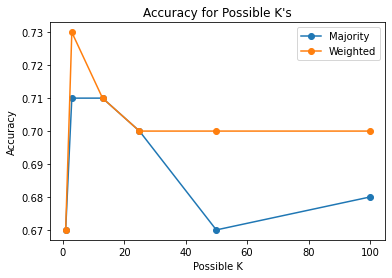

In [19]:
# plot code here

plt.plot(poss_k, acc_k_majority, label = "Majority", marker = "o")
plt.plot(poss_k, acc_k_weighted, label = "Weighted", marker = "o")
plt.xlabel('Possible K')
plt.ylabel('Accuracy')
plt.legend()

plt.title("Accuracy for Possible K's")

We would choose k = 13 in the weighted voting scheme, because it results in a relatively high accuracy with low dimensions based on the graph. Choosing the next lowest point, (k = 3), would result in instability because it is at an inflection point and is significantly different from the points before and after it. Additionally, using weighted voting can help counter class imbalance.